# Extract a tensor of features for debugging on the embedded device

In [1]:
import librosa as lr
import octafilt3r.filter as o3f
import octafilt3r.plot as o3p
import octafilt3r.weightings as o3w
import os
from tensorflow.keras.models import load_model
import numpy as np
import pipeline.config as conf
import pipeline.scale as scale

In [19]:
def df2c(fp, df, class_name):

    df = df[0] # drop first dimension

    code = f"// constant features auto-generated for ai-verification. Class: [{class_name}]\n\n"

    for frame in df:
        code += "{\n"
        for db in frame:
            code += f"{db},\n"
        code += "},\n"   
    
    with open(fp, 'w') as f:
        f.write(code)



(1, 40, 28, 1)
0.0057714139111340
0.9793586134910583
0.0100972140207887
0.0041780541650951
0.0003924568591174
0.0002022797416430
Predicted class: "car_horn" with 97 score.
----- done. -----
1 true predictions
0 false predictions
test accuracy: 100%
error ratio: 0%


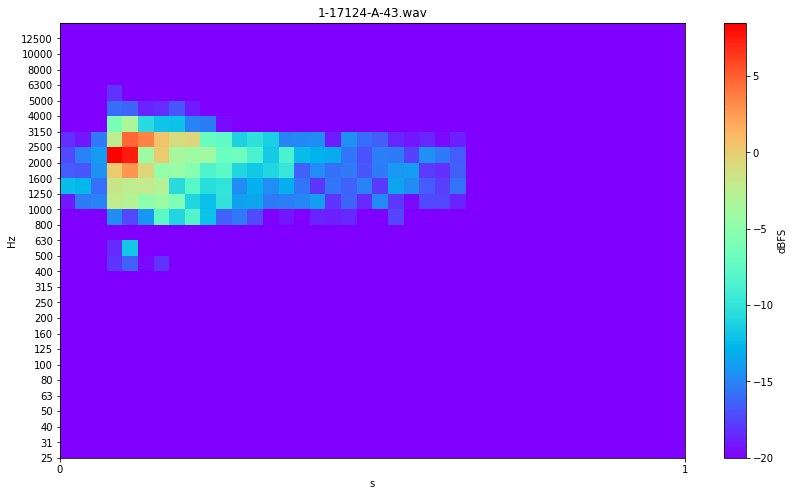

In [20]:
param_dict = conf.open_params()

class_of_interest = "car_horn"
base_path = "Datasets/ESC50_augmented/" + class_of_interest + "/"
stop_at = 1
i = 0
true = 0
false = 0

N4CED = load_model(param_dict["CNN_name"])

for file in os.listdir(base_path):

    if(i == stop_at):
        break

    """
    LOAD DATA
    """
    wav, fs = lr.load(base_path + file, sr=param_dict['fs'], duration=1)
    wav = o3w.A_weight(wav, fs)

    if len(wav) < fs:
        continue


    """
    EXTRACT FEATURES
    """
    feats, fcs, leqs = o3f.rolling_oct_bank(
        wav,
        fs,
        param_dict['oct_bw_ratio'],
        param_dict['order'],
        param_dict['fmax'],
        param_dict['fmin'],
        param_dict['frame_size'],
        param_dict['dec_stages'],
        param_dict['dec_ord']
    )


    """
    RESHAPE FEATURES
    """
    feats = feats[:, ::-1]
    df = scale.feats2frames(feats, param_dict['frame_size'], fs)
    

    """
    SCALE FEATURES
    """
    df = scale.normalize_dbfs(df, leqs, param_dict["threshold"])
    df2c("../STM32/Nu_L5_embedded_CNN_PoC_V-0-1/Core/Inc/SW/ai_verify.txt", df, class_of_interest)
    df = df[..., np.newaxis]
    print(df.shape)
    o3p.oct_spectrogram(df[0, :, ::-1, 0], 
                        fs, 
                        param_dict["frame_size"],
                        param_dict["fmax"],
                        param_dict["fmin"],
                        name=file)


    """
    RUN MODEL
    """
    p = N4CED.predict(df)


    """
    PROCESS RESULTS
    """
    for e in p[0]:
        print("{:.16f}".format(e))
    predicted = param_dict["class_map"][np.argmax(np.mean(p, axis=0))]
    print(f'Predicted class: "{predicted}" with {int(100 * (p[0][np.argmax(p, 1)][0]))} score.')
    if predicted == class_of_interest:
        true += 1
    else:
        false += 1
    i += 1

print('----- done. -----')
print(f'{true} true predictions\n{false} false predictions')
print(f'test accuracy: {int((true/i)*100)}%\nerror ratio: {int((false/i)*100)}%')